# Mecánica Celeste: teoría, algoritmos y problemas
# Por Jorge I. Zuluaga

En estos cuadernos hemos compilado la mayoría de los códigos que vienen con el libro [**Mecánica Celeste: teoría, algoritmos y problemas**](https://www.libreriadelau.com/bw-mecanica-celeste-teoria-algoritmos-y-problemas-u-de-antioquia-fisica/p). En cada cuaderno encontrará códigos de secciones o capítulos enteros. Para explicaciones detalladas de lo que hacen los códigos refiérase a la sección o capítulo respectivo. Para mayor comodidad puede leer o ejecutar este cuaderno usando `Google Colab`.

<a target="_blank" href="https://colab.research.google.com/github/seap-udea/pymcel/blob/main/ejemplos/cuadernos-libro/mcel_zuluaga-21-lagrangiano_fuerzas_centrales.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Algorítmos del formalismo lagrangiano: el problema de fuerzas centrales

### Instalación e importación

Si está usando este cuaderno en `Colab` debería instalar `pymcel` antes de comenzar: 

In [1]:
!pip install -Uq pymcel

In [2]:
# Este código se usa solamente para desarrollar estos cuadernos pero es inocuo en otros contextos
%load_ext autoreload 
%autoreload 2

### El problema general de los dos cuerpos en el formalismo lagrangiano

Implementemos los potenciales para una fuerza:

In [3]:
def Vfuerza(r,**parametros):
    V=-parametros["mu"]/r**parametros["n"]
    return V

def Vcen(r,**parametros):
    V=parametros["h"]**2/(2*r**2)
    return V

def Veff(r,Vf,**parametros):
    V=Vf(r,**parametros)+Vcen(r,**parametros)
    return V

Una gráfica del potencial efectivo, para valores característicos de los parámetros, se puede obtener con este algoritmo:

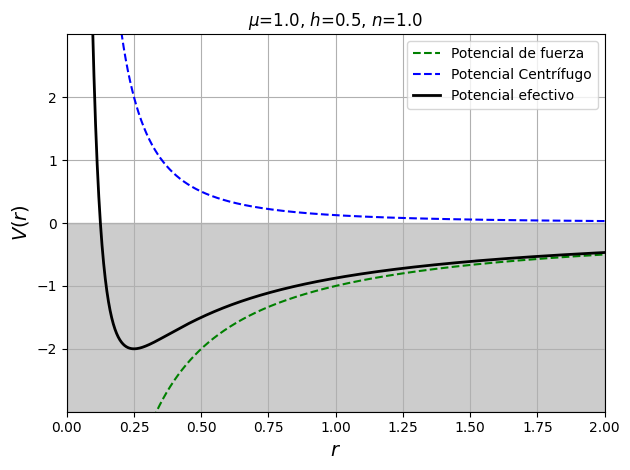

In [4]:
#Parámetros del potencial
mu=1.0
n=1.0
h=0.5

#Puntos en los que calculamos el potencial
rmax=2
from numpy import linspace
rs=linspace(1e-3,rmax,1000)

#Valores del potencial
Vs=Vfuerza(rs,mu=mu,n=n)
Vcens=Vcen(rs,h=h)
Veffs=Veff(rs,Vfuerza,h=h,mu=mu,n=n)

#Valores mínimo y máximo para el gráfico
Vmin=-1.5*abs(Veffs.min())
Vmax=+1.5*abs(Veffs.min())

#Gráfico
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()
ax.plot(rs,Vs,'g--',label='Potencial de fuerza')
ax.plot(rs,Vcens,'b--',label='Potencial Centrífugo')
ax.plot(rs,Veffs,'k-',lw=2,label="Potencial efectivo")

#Decoracion
ax.axhspan(Vmin,0,color='k',alpha=0.2)
ax.set_xlim((0,rmax))
ax.set_ylim((Vmin,Vmax))
ax.set_xlabel(r"$r$",fontsize=14)
ax.set_ylabel(r"$V(r)$",fontsize=14)
ax.set_title(f"$\mu$={mu}, $h$={h}, $n$={n}")
ax.legend()
ax.grid()
fig.tight_layout();

Hagamos un gráfico interactivo que nos permita ilustrar el potencial efectivo:

In [5]:
def potencial_doscuerpos(mu=1.0,h=1.0,n=1.0):
    #Puntos en los que calculamos el potencial
    rmax=5
    from numpy import linspace
    rs=linspace(1e-3,rmax,1000)
    Vs=Vfuerza(rs,mu=mu,n=n)
    Vcens=Vcen(rs,h=h)
    Veffs=Veff(rs,Vfuerza,h=h,mu=mu,n=n)
    Vmin=-3.5*abs(Veffs.min())
    Vmax=+2.5*abs(Veffs.min())

    #Gráfico
    import matplotlib.pyplot as plt
    fig=plt.figure()
    ax=fig.gca()
    ax.plot(rs,Vs,'g--',label='Potencial de fuerza')
    ax.plot(rs,Vcens,'b--',label='Potencial Centrífugo')
    ax.plot(rs,Veffs,'k-',lw=2,label="Potencial efectivo")
    ax.axhspan(Vmin,0,color='k',alpha=0.2)
    ax.set_xlim((0,rmax))
    ax.set_ylim((Vmin,Vmax))
    ax.set_xlabel(r"$r$")
    ax.set_ylabel(r"$V(r)$")
    ax.set_title(f"$\mu$={mu}, $h$={h}, $n$={n}")
    ax.legend()
    ax.grid()
    fig.tight_layout()    
   
# Widgets de Jupyter
from ipywidgets import interact,fixed,widgets
opciones=dict(continuous_update=False)

from ipywidgets import interact,fixed,widgets
interact(potencial_doscuerpos,
         mu=widgets.FloatSlider(min=0.1,max=2.0,step=0.1,value=1.0,**opciones),
         h=widgets.FloatSlider(min=0.1,max=2.0,step=0.1,value=1.0,**opciones),
         n=widgets.FloatSlider(min=-2.0,max=2.0,step=0.1,value=1.0,**opciones),
        );

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='mu', max=2.0, min=0.1), Flo…

### Ecuación de movimiento de la variable radial

Escribamos primero las rutinas que nos permiten determinar el valor de la fuerza específica para cualquier valor de  r y naturalmente definir el sistema linearizado de ecuaciones de movimiento.

In [6]:
def fuerza_especifica(r,**parametros):
    f=-n*parametros["mu"]/r**(parametros["n"]+1)
    return f

def edm_doscuerpos_general(Y,t,fuerza,parametros):
    #Leemos las variables
    r=Y[0]
    vr=Y[1]
    teta=Y[2]
    #Caculamos las derivadas
    drdt=vr
    dvrdt=fuerza(r,**parametros)+parametros["h"]**2/r**3
    dtetadt=parametros["h"]/r**2
    return [drdt,dvrdt,dtetadt]

Definamos ahora los parámetros y condiciones iniciales del sistema:

In [7]:
#Parámetros del potencial
mu=1
n=1.1

#Condiciones iniciales
r=1.0
teta=0.0
r_dot=0.0
teta_dot=0.5

#Momento angular específico
h=r**2*teta_dot

#Energía específica
from pymcel.export import Vfuerza,Vcen
epsilon=0.5*r_dot**2+Vfuerza(r,mu=mu,n=n)+Vcen(r,h=h)

#Tiempos de integración
Nt=1000
from numpy import linspace
ts=linspace(0.0,10.0,Nt)

Paquete pymcel cargado. Versión: 0.6.0


Integrando las ecuaciones de movimiento obtenemos:

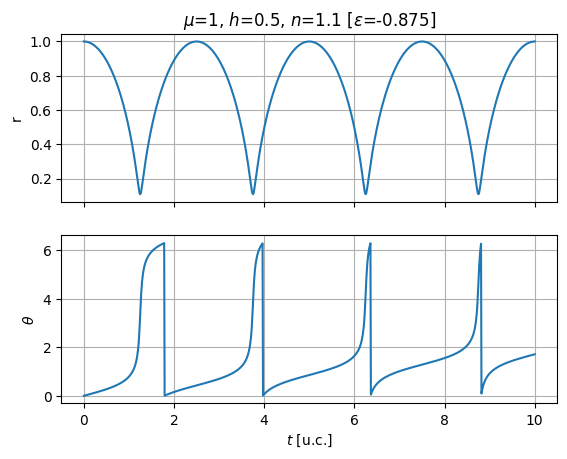

In [8]:
from scipy.integrate import odeint
solucion=odeint(edm_doscuerpos_general,[r,r_dot,teta],ts,
                args=(fuerza_especifica,dict(h=h,mu=mu,n=n)))
rs=solucion[:,0]
from numpy import mod,pi
tetas=mod(solucion[:,2],2*pi)

import matplotlib.pyplot as plt
fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(ts,rs)
axs[0].set_ylabel('r')
axs[0].grid()
axs[0].set_title(f"$\mu$={mu}, $h$={h}, $n$={n} [$\epsilon$={epsilon}]")
from numpy import mod
axs[1].plot(ts,tetas)
axs[1].set_ylabel("$\\theta$")
axs[1].set_xlabel("$t$ [u.c.]");
axs[1].grid()

Para comprender estos resultados, lo mejor es representar la trayectoria en el espacio coordenado:



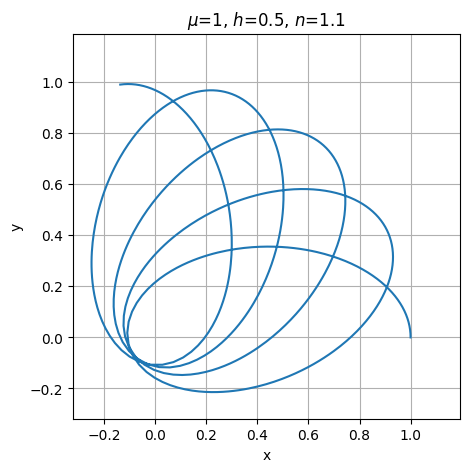

In [9]:

#Conversión de (r,teta) a (x, y)
from numpy import cos,sin
xs=rs*cos(tetas)
ys=rs*sin(tetas)

#Gráfico
fig=plt.figure(figsize=(5,5))
ax=fig.gca()
ax.plot(xs,ys)

#Decoración
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"$\mu$={mu}, $h$={h}, $n$={n}")
ax.grid();
from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(ax,(xs,ys),margin=0.1);

Finalmente podemos hacer un gráfico del potencial efectivo para este sistema, que nos permitirá conectar la solución a las ecuaciones de movimiento con la teoría del potencial y las regiones de exclusión que estudiamos en la sección anterior:

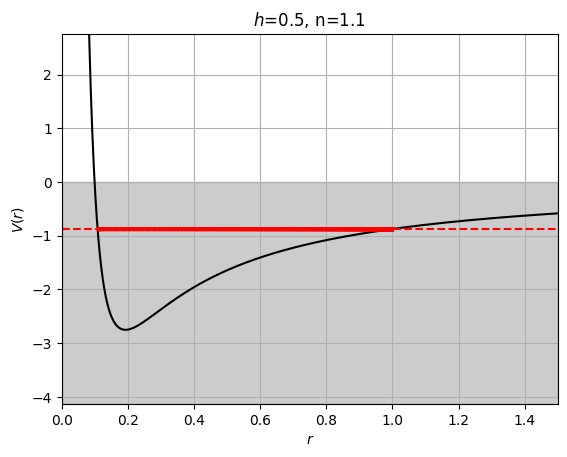

In [10]:
#Calculo del potencial
rmax=1.5*rs.max()
res=linspace(1e-3,rmax,1000)
from pymcel.export import Veff
Veffs=Veff(res,Vfuerza,h=h,mu=mu,n=n)
Vmin=-1.5*abs(Veffs.min())
Vmax=+1.0*abs(Veffs.min())

#Gráfico
fig=plt.figure()
ax=fig.gca()
ax.plot(res,Veffs,'k-')
ax.axhspan(Vmin,0,color='k',alpha=0.2)
ax.axhline(epsilon,color='r',ls='--')

#Valores de rs
from numpy import ones_like
ax.plot(rs,epsilon*ones_like(rs),'rv',ms=2)

#Decoración
ax.set_xlim((0,rmax))
ax.set_ylim((Vmin,Vmax))
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$V(r)$")
ax.set_title(f"$\mu$={mu}, $h$={h}, $n$={n}")
ax.set_title(r"$h$=%g, n=%g"%(h,n))
ax.grid()

### El problema de los 2 cuerpos con $n$ arbitrario

El siguiente algoritmo permite comparar, visualmente, la contribución que cada uno de estos términos hace en la solución final obtenida en la Ecuación de precesión del eje de la órbita:

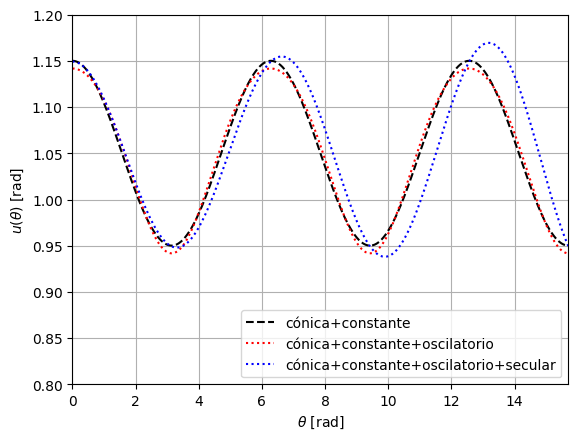

In [11]:
#Parametros del sistema
q=0.05
p=1.0
e=0.1

#Valores de teta
from numpy import linspace,sin,cos,pi
teta_min=0.0
teta_max=5*pi
tetas=linspace(teta_min,teta_max,1000)

#Términos de u
u_conica=(1/p)*(1+e*cos(tetas))
u_constante=(q/p)*(1+e**2/2)
u_secular=(q/p)*e*tetas*sin(tetas)
u_oscilatorio=-(q/p)*(e/6)*cos(2*tetas)

#Gráfico
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()

ax.plot(tetas,u_conica+u_constante,'k--',label="cónica+constante")
ax.plot(tetas,u_conica+u_constante+10*u_oscilatorio,'r:',
        label="cónica+constante+oscilatorio")
ax.plot(tetas,u_conica+u_constante+u_oscilatorio+u_secular,'b:',
        label="cónica+constante+oscilatorio+secular")

#Decoración
ax.legend(loc='lower right')
ax.set_xlabel("$\\theta$ [rad]")
ax.set_ylabel("$u(\\theta)$ [rad]")
ax.set_xlim((teta_min,teta_max))
ax.set_ylim((0.8,1.2))
ax.grid();

<hr/>

Para explorar más cuadernos del libro vaya al [repositorio de en GitHub](https://github.com/seap-udea/pymcel/tree/main/ejemplos/cuadernos-libro)